# Solving PDEs using finite elements and finite differences

We consider the following model problem:
$$
\begin{gather*}
    \partial_t u(t,x) = \partial_x^2u(t,x), \quad 0 < t \le T, \quad 0 < x < 1,\\
    u(0,x) = u_0(x), \quad 0 < x < 1,\\
    u(t, 0) = u(t,1) = 0, \quad 0 \le t \lt T.
\end{gather*}
$$
We will solve this problem for the initial value
$$
    u_0(x) = \sin(\pi x)
$$
leading to the explicit solution
$$
    u(t,x) = \exp\left( - \pi^2 t \right) \sin(\pi x).
$$

## 1. Finite element method

In this presentation, we are not implementing our own FEM solver, but we rather use a well-established, powerful library. In this case, we use **FEniCS**.

We implement the backward and forward Euler, and then the general $\theta$-scheme.

In [1]:
import sys
import fenics as fe
from fenics import dx, grad, dot
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spl
import matplotlib.pyplot as plt

In [2]:
def backward_euler_fem(u_0_expression, t_final, N, M, plot_p = False):
    """Compute the solution of the model problem by backward Euler FEM.

    Parameters
    ----------
    u_0_expression : string. Expression for the initial condition.
    t_final : float. Terminal time.
    N : int. Parameter determining the mesh in space.
    M : int. Parameter determining the number of timesteps.
    plot_p : bool. If true, then solution is plotted.

    Output
    ------
    u : Function. The approximate solution at time t_final.
    mesh : UnitIntervalMesh. The grid in space used.
    """
    dt = t_final / M
    mesh = fe.UnitIntervalMesh(N)

    V = fe.FunctionSpace(mesh, 'P', 1) # The space of test functions

    # Define boundary condition
    def boundary(x, on_boundary):
        return on_boundary
    bc = fe.DirichletBC(V, fe.Constant(0), boundary)

    # Define initial value
    u_0 = fe.Expression(u_0_expression, degree=1)
    u_n = fe.interpolate(u_0, V) # placeholder for the previous value in the timestepping.
    if plot_p:
        fe.plot(u_n)

    # Define variational problem
    u = fe.TrialFunction(V)
    v = fe.TestFunction(V)

    F = u*v*dx + dt*dot(grad(u), grad(v))*dx - u_n*v*dx
    a, L = fe.lhs(F), fe.rhs(F)
    
    # Time-stepping
    u = fe.Function(V) # the unknown. Redefine for the actual solution.
    t = 0
    for n in range(M):
        t += dt # Update current time 
        fe.solve(a == L, u, bc) # Compute solution
        if plot_p:
            fe.plot(u)       
        u_n.assign(u) # Update previous solution

    return u, mesh

In [3]:
def forward_euler_fem(u_0_expression, t_final, N, M, plot_p = False):
    """Compute the solution of the model problem by forward Euler FEM.

    Parameters
    ----------
    u_0_expression : string. Expression for the initial condition.
    t_final : float. Terminal time.
    N : int. Parameter determining the mesh in space.
    M : int. Parameter determining the number of timesteps.
    plot_p : bool. If true, then solution is plotted.

    Output
    ------
    u : Function. The approximate solution at time t_final.
    mesh : UnitIntervalMesh. The grid in space used.
    """
    dt = t_final / M
    mesh = fe.UnitIntervalMesh(N)

    V = fe.FunctionSpace(mesh, 'P', 1) # The space of test functions

    # Define boundary condition
    def boundary(x, on_boundary):
        return on_boundary
    bc = fe.DirichletBC(V, fe.Constant(0), boundary)

    # Define initial value
    u_0 = fe.Expression(u_0_expression, degree=1)
    u_n = fe.interpolate(u_0, V) # placeholder for the previous value in the timestepping.
    if plot_p:
        fe.plot(u_n)

    # Define variational problem
    u = fe.TrialFunction(V)
    v = fe.TestFunction(V)

    F = u*v*dx + dt*dot(grad(u_n), grad(v))*dx - u_n*v*dx
    a, L = fe.lhs(F), fe.rhs(F)
    
    # Time-stepping
    u = fe.Function(V) # the unknown. Redefine for the actual solution.
    t = 0
    for n in range(M):
        t += dt # Update current time 
        fe.solve(a == L, u, bc) # Compute solution
        if plot_p:
            fe.plot(u)       
        u_n.assign(u) # Update previous solution

    return u, mesh

In [4]:
def theta_euler_fem(theta, u_0_expression, t_final, N, M, plot_p = False):
    """Compute the solution of the model problem by backward Euler FEM.

    Parameters
    ----------
    theta : floar. Between 0 and 1.
    u_0_expression : string. Expression for the initial condition.
    t_final : float. Terminal time.
    N : int. Parameter determining the mesh in space.
    M : int. Parameter determining the number of timesteps.
    plot_p : bool. If true, then solution is plotted.

    Output
    ------
    u : Function. The approximate solution at time t_final.
    mesh : UnitIntervalMesh. The grid in space used.
    """
    dt = t_final / M
    mesh = fe.UnitIntervalMesh(N)

    V = fe.FunctionSpace(mesh, 'P', 1) # The space of test functions

    # Define boundary condition
    def boundary(x, on_boundary):
        return on_boundary
    bc = fe.DirichletBC(V, fe.Constant(0), boundary)

    # Define initial value
    u_0 = fe.Expression(u_0_expression, degree=1)
    u_n = fe.interpolate(u_0, V) # placeholder for the previous value in the timestepping.
    if plot_p:
        fe.plot(u_n)

    # Define variational problem
    u = fe.TrialFunction(V)
    v = fe.TestFunction(V)

    F = u*v*dx + dt*dot(theta * grad(u) + (1-theta) * grad(u_n), grad(v))*dx - u_n*v*dx
    a, L = fe.lhs(F), fe.rhs(F)
    
    # Time-stepping
    u = fe.Function(V) # the unknown. Redefine for the actual solution.
    t = 0
    for n in range(M):
        t += dt # Update current time 
        fe.solve(a == L, u, bc) # Compute solution
        if plot_p:
            fe.plot(u)       
        u_n.assign(u) # Update previous solution

    return u, mesh

Define functions for computing the $L^2$, $L^\infty$ and $H^1$ errors.

In [5]:
def norm_L2(v, w):
    """
    Compute the L^2-distance between v and w.

    Note: For some reason, the numerical solution has to be the second argument.

    Parameters
    ----------
    v : fe.Function.
    w : fe.Function.
    """
    return fe.errornorm(v, w, 'L2')

def norm_H1(v, w):
    """
    Compute the H^1-distance between v and w.

    Note: For some reason, the numerical solution has to be the second argument.

    Parameters
    ----------
    v : fe.Function.
    w : fe.Function.
    """
    return fe.errornorm(v, w, 'H1')

def norm_Linf(v, w, mesh):
    """
    Compute the L^infty-distance between v and w.

    Parameters
    ----------
    v : fe.Function.
    w : fe.Function.
    mesh : A mesh on which the maximum is taken.
    """
    vertex_values_v = v.compute_vertex_values(mesh)
    vertex_values_w = w.compute_vertex_values(mesh)
    return np.max(np.abs(vertex_values_v - vertex_values_w))

Test it once.

u_approx(0.5, 0.2) = 0.004754401777896201, u_exact(0.5, 0.2) = 0.00422728297276244.
L2-error = 0.0006336545652862388.
H1-error = 0.002095446080526122.
Linfty-error = 0.0008967880753693487.


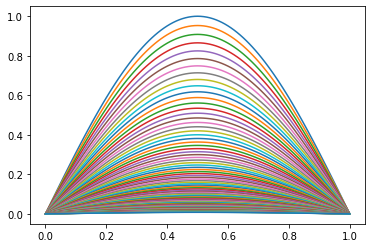

In [6]:
u_0_expression = 'sin(pi * x[0])'
N = 100
M = 100
t_final = 0.5

u, mesh = backward_euler_fem(u_0_expression, t_final, N, M, True)
print(f"u_approx(0.5, 0.2) = {u(0.2)}, u_exact(0.5, 0.2) = {np.exp(-np.pi**2 * 0.5) * np.sin(np.pi * 0.2)}.")

u_exact_expression = 'exp(-pi*pi*t) * sin(pi * x[0])'
u_exact = fe.Expression(u_exact_expression, degree=1, t=t_final)
print(f"L2-error = {norm_L2(u_exact, u)}.")
print(f"H1-error = {norm_H1(u_exact, u)}.")
print(f"Linfty-error = {norm_Linf(u, u_exact, mesh)}.")

Now try the forward Euler method with the same parameters.

u_approx(0.5, 0.2) = 5.550542992136069e+260, u_exact(0.5, 0.2) = 0.00422728297276244.
L2-error = inf.
H1-error = inf.
Linfty-error = 2.7284163457071907e+261.


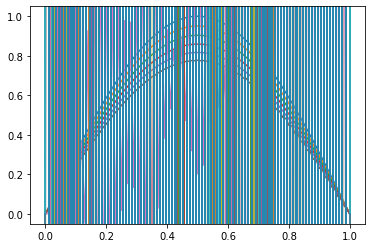

In [7]:
u_0_expression = 'sin(pi * x[0])'
N = 100
M = 100
t_final = 0.5

u_forward, mesh = forward_euler_fem(u_0_expression, t_final, N, M, True)
print(f"u_approx(0.5, 0.2) = {u_forward(0.2)}, u_exact(0.5, 0.2) = {np.exp(-np.pi**2 * 0.5) * np.sin(np.pi * 0.2)}.")

u_exact_expression = 'exp(-pi*pi*t) * sin(pi * x[0])'
u_exact = fe.Expression(u_exact_expression, degree=1, t=t_final)
print(f"L2-error = {norm_L2(u_exact, u_forward)}.")
print(f"H1-error = {norm_H1(u_exact, u_forward)}.")
print(f"Linfty-error = {norm_Linf(u_forward, u_exact, mesh)}.")

We clearly see the effect of instability.

u_approx(0.5, 0.2) = 5.550542992136069e+260, u_exact(0.5, 0.2) = 0.00422728297276244.
L2-error = 7.5749274715881216e-06.
H1-error = 0.00014681573375036733.
Linfty-error = 1.0118650489653394e-05.


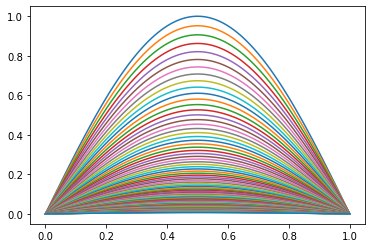

In [8]:
u_0_expression = 'sin(pi * x[0])'
N = 100
M = 100
t_final = 0.5
theta = 0.5

u_cr, mesh = theta_euler_fem(theta, u_0_expression, t_final, N, M, True)
print(f"u_approx(0.5, 0.2) = {u_forward(0.2)}, u_exact(0.5, 0.2) = {np.exp(-np.pi**2 * 0.5) * np.sin(np.pi * 0.2)}.")

u_exact_expression = 'exp(-pi*pi*t) * sin(pi * x[0])'
u_exact = fe.Expression(u_exact_expression, degree=1, t=t_final)
print(f"L2-error = {norm_L2(u_exact, u_cr)}.")
print(f"H1-error = {norm_H1(u_exact, u_cr)}.")
print(f"Linfty-error = {norm_Linf(u_cr, u_exact, mesh)}.")

## 2. Convergence rates for the FEM solvers

We check convergence rates in $N$ and $M$ for the different solvers.

In [9]:
def error_gen(solver, u_exact, N, M):
    if len(N) == 1:
        N = np.full_like(M, N[0])
    elif len(M) == 1:
        M = np.full_like(N, M[0])
    assert len(N) == len(M)

    err_L2 = np.zeros(len(M))
    err_H1 = np.zeros(len(M))
    err_Linf = np.zeros(len(M))
    for i in range(len(M)):
        print(f"Iteration {i+1} of {len(M)} with N = {N[i]}, M = {M[i]}.")
        u, mesh = solver(N[i], M[i])
        err_L2[i] = norm_L2(u_exact, u)
        err_H1[i] = norm_H1(u_exact, u)
        err_Linf[i] = norm_Linf(u_exact, u, mesh)
    
    return err_L2, err_H1, err_Linf

### 2.1 Time discretization error

Start with backward Euler.

In [10]:
N = 2**12
M = 2**np.arange(3,12) 
t_final = 0.5
u_0_expression = 'sin(pi * x[0])'
u_exact_expression = 'exp(-pi*pi*t) * sin(pi * x[0])'
u_exact = fe.Expression(u_exact_expression, degree=1, t=t_final)
back_solver = lambda n, m: backward_euler_fem(u_0_expression, t_final, n, m, False)
err_L2, err_H1, err_Linf = error_gen(back_solver, u_exact, np.array([N]), M)

Iteration 1 of 9 with N = 4096, M = 8.
Iteration 2 of 9 with N = 4096, M = 16.
Iteration 3 of 9 with N = 4096, M = 32.
Iteration 4 of 9 with N = 4096, M = 64.
Iteration 5 of 9 with N = 4096, M = 128.
Iteration 6 of 9 with N = 4096, M = 256.
Iteration 7 of 9 with N = 4096, M = 512.
Iteration 8 of 9 with N = 4096, M = 1024.
Iteration 9 of 9 with N = 4096, M = 2048.


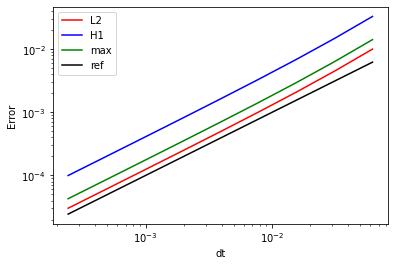

In [11]:
dt = t_final / M
plt.loglog(dt, err_L2, "r-", label="L2")
plt.loglog( dt, err_H1, 'b-', label="H1")
plt.loglog(dt, err_Linf, 'g-', label="max")
plt.loglog(dt, 0.1*dt, 'k-', label="ref")
plt.legend(loc = "upper left")
plt.xlabel("dt")
plt.ylabel("Error")
plt.show()

Continue with the Crank Nicolson scheme.

In [12]:
N = 2**12
M = 2**np.arange(3,12) 
t_final = 0.5
u_0_expression = 'sin(pi * x[0])'
u_exact_expression = 'exp(-pi*pi*t) * sin(pi * x[0])'
u_exact = fe.Expression(u_exact_expression, degree=1, t=t_final)
cr_solver = lambda n, m: theta_euler_fem(0.5, u_0_expression, t_final, n, m, False)
err_L2, err_H1, err_Linf = error_gen(cr_solver, u_exact, np.array([N]), M)

Iteration 1 of 9 with N = 4096, M = 8.
Iteration 2 of 9 with N = 4096, M = 16.
Iteration 3 of 9 with N = 4096, M = 32.
Iteration 4 of 9 with N = 4096, M = 64.
Iteration 5 of 9 with N = 4096, M = 128.
Iteration 6 of 9 with N = 4096, M = 256.
Iteration 7 of 9 with N = 4096, M = 512.
Iteration 8 of 9 with N = 4096, M = 1024.
Iteration 9 of 9 with N = 4096, M = 2048.


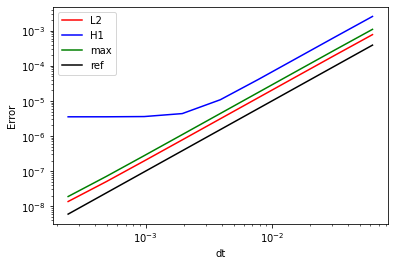

In [13]:
dt = t_final / M
plt.loglog(dt, err_L2, "r-", label="L2")
plt.loglog( dt, err_H1, 'b-', label="H1")
plt.loglog(dt, err_Linf, 'g-', label="max")
plt.loglog(dt, 0.1*dt**2, 'k-', label="ref")
plt.legend(loc = "upper left")
plt.xlabel("dt")
plt.ylabel("Error")
plt.show()

### 2.2 Space discretization error

Once again, start with the backward Euler method.

In [14]:
M = np.array([2**15])
N = 2**np.arange(1,10) 
t_final = 0.5
u_0_expression = 'sin(pi * x[0])'
u_exact_expression = 'exp(-pi*pi*t) * sin(pi * x[0])'
u_exact = fe.Expression(u_exact_expression, degree=1, t=t_final)
back_solver = lambda n, m: backward_euler_fem(u_0_expression, t_final, n, m, False)
err_L2, err_H1, err_Linf = error_gen(back_solver, u_exact, N, M)

Iteration 1 of 9 with N = 2, M = 32768.
Iteration 2 of 9 with N = 4, M = 32768.
Iteration 3 of 9 with N = 8, M = 32768.
Iteration 4 of 9 with N = 16, M = 32768.
Iteration 5 of 9 with N = 32, M = 32768.
Iteration 6 of 9 with N = 64, M = 32768.
Iteration 7 of 9 with N = 128, M = 32768.
Iteration 8 of 9 with N = 256, M = 32768.
Iteration 9 of 9 with N = 512, M = 32768.


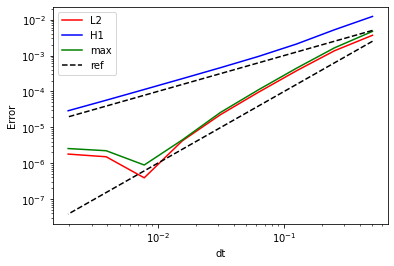

In [15]:
h = 1.0 / N
plt.loglog(h, err_L2, "r-", label="L2")
plt.loglog(h, err_H1, 'b-', label="H1")
plt.loglog(h, err_Linf, 'g-', label="max")
plt.loglog(h, 0.01*h**2, 'k--', label="ref")
plt.loglog(h, 0.01*h, 'k--')
plt.legend(loc = "upper left")
plt.xlabel("dt")
plt.ylabel("Error")
plt.show()

Now let us try Crank Nicolson again.

In [16]:
M = np.array([2**15])
N = 2**np.arange(1,10) 
t_final = 0.5
u_0_expression = 'sin(pi * x[0])'
u_exact_expression = 'exp(-pi*pi*t) * sin(pi * x[0])'
u_exact = fe.Expression(u_exact_expression, degree=1, t=t_final)
cr_solver = lambda n, m: theta_euler_fem(0.5, u_0_expression, t_final, n, m, False)
err_L2, err_H1, err_Linf = error_gen(cr_solver, u_exact, N, M)

Iteration 1 of 9 with N = 2, M = 32768.
Iteration 2 of 9 with N = 4, M = 32768.
Iteration 3 of 9 with N = 8, M = 32768.
Iteration 4 of 9 with N = 16, M = 32768.
Iteration 5 of 9 with N = 32, M = 32768.
Iteration 6 of 9 with N = 64, M = 32768.
Iteration 7 of 9 with N = 128, M = 32768.
Iteration 8 of 9 with N = 256, M = 32768.
Iteration 9 of 9 with N = 512, M = 32768.


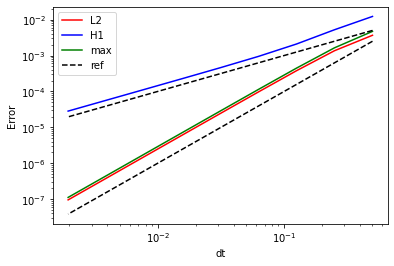

In [17]:
h = 1.0 / N
plt.loglog(h, err_L2, "r-", label="L2")
plt.loglog(h, err_H1, 'b-', label="H1")
plt.loglog(h, err_Linf, 'g-', label="max")
plt.loglog(h, 0.01*h**2, 'k--', label="ref")
plt.loglog(h, 0.01*h, 'k--')
plt.legend(loc = "upper left")
plt.xlabel("dt")
plt.ylabel("Error")
plt.show()

## 3. Finite differences

### 3.1. Forward Euler.

We start with the forward Euler scheme. Recall that
$$
u_{i+1,j} = u_{i,j} + \lambda \left( u_{i,j+1} - 2 u_{i,j} + u_{i,j-1}\right), \quad j=1, \ldots, M-1, \quad u_{i+1,0} = u_{i+1, M} = 0,
$$
where $\lambda = \frac{\Delta t}{\Delta x^2}$. Denoting $u_i := (u_{i,j})_{j=1}^{M-1}$ and
$$
    A:=\begin{pmatrix}
        1-2\lambda & \lambda & 0 & \cdots & 0 \\
        \lambda & 1-2\lambda & \ddots & \ddots & \vdots \\
        \vdots & \ddots & \ddots & \ddots & \lambda \\
        0 & \cdots & 0 & \lambda & 1-2\lambda
      \end{pmatrix},
$$
this implies that $u_{i+1} = A u_i$, and $u_{i,:} = \bigl( 0, u_i, 0 \bigr)$.

**Note:** Confusingly, the roles of $N$ and $M$ were swapped between FEM and FD! So, $N$ now corresponds to timesteps and $M$ to space meshes.

In [19]:
def generate_forward_matrix(lam, M):
    """Generate the above matrix A."""
    return np.diag(np.full(M-1, 1-2*lam)) + np.diagflat(np.full(M-2, lam), 1) + np.diagflat(np.full(M-2, lam), -1)

def forward_FD(u_0, t_final, N, M):
    """Compute explicit finite difference solution to the heat equation with 0 Dirichlet boundary values.
    
    Parameters
    ----------
    u_0 : function. Initial condition of the PDE.
    t_final : float. Terminal time.
    N : int. Number of timesteps.
    M : int. Mesh-size of the space grid in the above sense.
    
    Output
    ------
    u : array. Approximate value of u(t_final, .) at the space-grid."""
    dt = t_final / N
    x = np.linspace(0.0, 1.0, M+1)
    dx = 1 / M
    
    # compute the intial value of u
    u = u_0(x)
    u_red = u[1:M]
    
    # set up the matrix A
    A = generate_forward_matrix(dt / dx**2, M)
    
    # Apply the iteration
    for n in range(N):
        u_red = A @ u_red

    u[1:M] = u_red
    
    return u

Now try it out with reasonable parameters for our model problem.

u(0.5, 0.2) = 0.00422728297276244, u_FD(0.5, 0.2) = 0.004349220987439515.


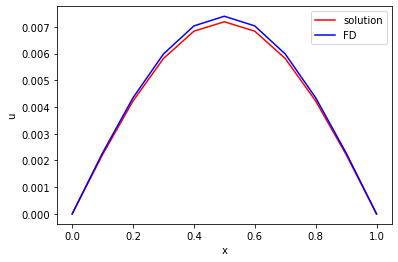

In [20]:
def u_exact(t, x):
    return np.exp(-np.pi**2 * t) * np.sin(np.pi * x)
u_0 = lambda x: u_exact(0.0, x)

M = 10
N = 1000
t_final = 0.5

u_approx = forward_FD(u_0, t_final, N, M)

x = np.linspace(0.0, 1.0, M+1)
u = u_exact(t_final, x)

print(f"u({t_final}, 0.2) = {u_exact(t_final, 0.2)}, u_FD({t_final}, 0.2) = {u_approx[2]}.")

plt.plot(x, u, 'r-', label="solution")
plt.plot(x, u_approx, 'b-', label="FD")
plt.xlabel("x")
plt.ylabel("u")
plt.legend(loc = "upper right")
plt.show()

As suggested in the lecture, let us now try the same thing with $N = 50$.

u(0.5, 0.2) = 0.00422728297276244, u_FD(0.5, 0.2) = -655930.7604549348.


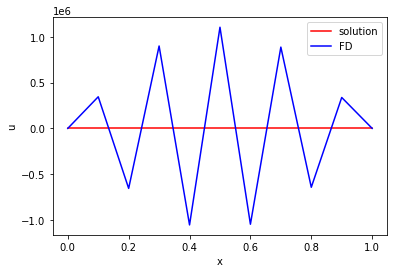

In [21]:
def u_exact(t, x):
    return np.exp(-np.pi**2 * t) * np.sin(np.pi * x)
u_0 = lambda x: u_exact(0.0, x)

M = 10
N = 50
t_final = 0.5

u_approx = forward_FD(u_0, t_final, N, M)

x = np.linspace(0.0, 1.0, M+1)
u = u_exact(t_final, x)

print(f"u({t_final}, 0.2) = {u_exact(t_final, 0.2)}, u_FD({t_final}, 0.2) = {u_approx[2]}.")

plt.plot(x, u, 'r-', label="solution")
plt.plot(x, u_approx, 'b-', label="FD")
plt.xlabel("x")
plt.ylabel("u")
plt.legend(loc = "upper right")
plt.show()

The matrix $A$ may become very big, but it is typically very sparse. Hence, we may use `scipy.sparse` to be able to accomodate larger dimensions.

In [22]:
lam = 0.2
M = 1000
A_full = np.diag(np.full(M-1, 1-2*lam)) + np.diagflat(np.full(M-2, lam), 1) + np.diagflat(np.full(M-2, lam), -1)
A_sparse = sp.diags(np.full(M-1, 1-2*lam)) + sp.diags(np.full(M-2, lam), 1) + sp.diags(np.full(M-2, lam), -1)
diff_mean = np.mean(np.abs(A_sparse.toarray() - A_full))
print(f"Size of A_full = {sys.getsizeof(A_full)}, size of A_sparse = {sys.getsizeof(A_sparse)}.")
print(f"The difference between A_full and A_sparse is {diff_mean}.")

Size of A_full = 7984128, size of A_sparse = 48.
The difference between A_full and A_sparse is 0.0.


Let us check if we pay a price in performance.

In [23]:
x = np.linspace(0, 1, M+1)
u_red = u_0(x)[1:M]

u_full = A_full @ u_red
u_sparse = A_sparse.dot(u_red)

print(f"The difference between the products is {np.mean(np.abs(u_full - u_sparse))}.")

%timeit A_full @ u_red
%timeit A_sparse.dot(u_red)

The difference between the products is 7.605694519297713e-18.
54.3 µs ± 1.93 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
6.22 µs ± 23.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Note that the sparse matrix product is, in fact, considerably fast than the dense one.

## 3.2 Backward finite differences

In the backward scheme, we consider
$$
u_{i,j} = u_{i+1,j} - \lambda \big( u_{i+1,j+1} - 2u_{i+1,j} +u_{i+1,j-1} \big),
$$
which leads to $Bu_{i+1} = u_i$ with
$$
    B := \begin{pmatrix}
        1+2\lambda & -\lambda & 0 & \cdots & 0 \\
        -\lambda & 1+2\lambda & \ddots & \ddots & \vdots \\
        \vdots & \ddots & \ddots & \ddots & -\lambda \\
        0 & \cdots & 0 & -\lambda & 1+2\lambda
      \end{pmatrix}.
$$

In [24]:
def generate_backward_matrix_dense(lam, M):
    """Generate the above matrix B."""
    return np.diag(np.full(M-1, 1+2*lam)) + np.diagflat(np.full(M-2, -lam), 1) + np.diagflat(np.full(M-2, -lam), -1)

def generate_backward_matrix_sparse(lam, M):
    """Sparse version."""
    return sp.diags(np.full(M-1, 1+2*lam)) + sp.diags(np.full(M-2, -lam), 1) + sp.diags(np.full(M-2, -lam), -1)

Before continuing, let us see how to solve a linear system of equations efficiently.

In [25]:
lam = 0.2
M = 1000
B_full = generate_backward_matrix_dense(lam, M)
B_sparse = generate_backward_matrix_sparse(lam, M)
diff_mean = np.mean(np.abs(A_sparse.toarray() - A_full))
print(f"Size of B_full = {sys.getsizeof(B_full)}, size of B_sparse = {sys.getsizeof(B_sparse)}.")
print(f"The difference between B_full and B_sparse is {diff_mean}.")

x = np.linspace(0, 1, M+1)
u_red = u_0(x)[1:M]

print("Solve linear system by inverting matrix.")
def f(C, x):
    C_inv = np.linalg.inv(C)
    return C @ x
u_1 = f(B_full, u_red)
%timeit f(B_full, u_red)

print("Solve linear system directly.")
u_2 = np.linalg.solve(B_full, u_red)
%timeit np.linalg.solve(B_full, u_red)

print("Solve linear system by inverting sparse matrix.")
def g(C, x):
    C_inv = spl.inv(C)
    return C.dot(x)
u_3 = g(B_sparse, u_red)
%timeit g(B_sparse, u_red)

print("Solve sparse linear system directly.")
u_4 = spl.spsolve(B_sparse, u_red)
%timeit spl.spsolve(B_sparse, u_red)

print("Check that solutions are equal.")
print(f"|u_1 - u_2| = {np.mean(np.abs(u_1-u_2))}.")
print(f"|u_1 - u_3| = {np.mean(np.abs(u_1-u_3))}.")
print(f"|u_1 - u_4| = {np.mean(np.abs(u_1-u_4))}.")

Size of B_full = 7984128, size of B_sparse = 48.
The difference between B_full and B_sparse is 0.0.
Solve linear system by inverting matrix.
27 ms ± 3.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Solve linear system directly.
8.36 ms ± 483 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Solve linear system by inverting sparse matrix.
/home/bayerc/anaconda3/envs/fenics/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/bayerc/anaconda3/envs/fenics/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
221 ms ± 7.11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Solve sparse linear system directly.
765 µs ± 16.6 µs per loop (mean ± std. dev. of 7 runs, 

Hence, the sparse solver `spsolve` is most efficient. Note that sparse inversion is not helpful, as the inverse matrix $B^{-1}$ is not sparse.

However, we need to solve the same linear system, with different right hand sides, many times. This *will* change the picture.

In [26]:
def f(C, x, m):
    C_inv = np.linalg.inv(C)
    for i in range(m):
        x = C_inv @ x
    return x

print("Dense inversion.")
u_1 = f(B_full, u_red, 100)
%timeit f(B_full, u_red, 100)

def g(C, x, m):
    C_sol = spl.splu(C)
    for i in range(m):
        x = C_sol.solve(x)
    return x

print("Sparse LU.")
u_2 = g(B_sparse, u_red, 100)
%timeit g(B_sparse, u_red, 100)

print(f"|u_1 - u_2| = {np.mean(np.abs(u_1 - u_2))}.")

B_sol = spl.splu(B_sparse)
print(f"Size of B_sol = {sys.getsizeof(B_sol)}.")

Dense inversion.
41 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Sparse LU.
5.4 ms ± 151 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
|u_1 - u_2| = 7.183001100547998e-15.
Size of B_sol = 144.


In total, a sparse LU-decomposition seems the fastest alternative, which, in addition, leads to a very small memory footprint.

In [27]:
def backward_FD(u_0, t_final, N, M):
    """Compute explicit finite difference solution to the heat equation with 0 Dirichlet boundary values.
    
    Parameters
    ----------
    u_0 : function. Initial condition of the PDE.
    t_final : float. Terminal time.
    N : int. Number of timesteps.
    M : int. Mesh-size of the space grid in the above sense.
    
    Output
    ------
    u : array. Approximate value of u(t_final, .) at the space-grid."""
    dt = t_final / N
    x = np.linspace(0.0, 1.0, M+1)
    dx = 1 / M
    
    # compute the intial value of u
    u = u_0(x)
    u_red = u[1:M]
    
    # set up the matrix A
    B = generate_backward_matrix_sparse(dt / dx**2, M)
    B_sol = spl.splu(B)
    
    # Apply the iteration
    for n in range(N):
        u_red = B_sol.solve(u_red)

    u[1:M] = u_red
    
    return u

Try with the same set of parameters as with the explicit difference method.

u(0.5, 0.2) = 0.00422728297276244, u_FD(0.5, 0.2) = 0.004454664184430334.


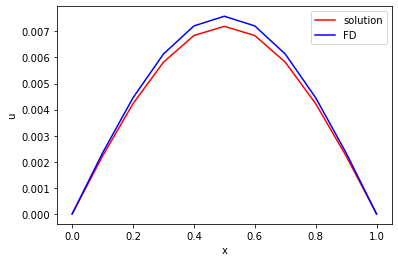

In [28]:
def u_exact(t, x):
    return np.exp(-np.pi**2 * t) * np.sin(np.pi * x)
u_0 = lambda x: u_exact(0.0, x)

M = 10
N = 1000
t_final = 0.5

u_approx = backward_FD(u_0, t_final, N, M)

x = np.linspace(0.0, 1.0, M+1)
u = u_exact(t_final, x)

print(f"u({t_final}, 0.2) = {u_exact(t_final, 0.2)}, u_FD({t_final}, 0.2) = {u_approx[2]}.")

plt.plot(x, u, 'r-', label="solution")
plt.plot(x, u_approx, 'b-', label="FD")
plt.xlabel("x")
plt.ylabel("u")
plt.legend(loc = "upper right")
plt.show()

u(0.5, 0.2) = 0.00422728297276244, u_FD(0.5, 0.2) = 0.0055123552292200804.
/home/bayerc/anaconda3/envs/fenics/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


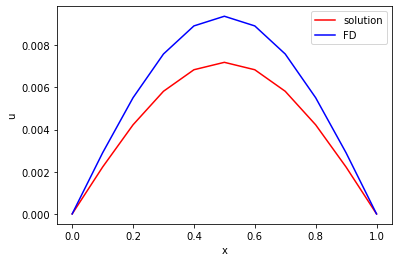

In [29]:
def u_exact(t, x):
    return np.exp(-np.pi**2 * t) * np.sin(np.pi * x)
u_0 = lambda x: u_exact(0.0, x)

M = 10
N = 50
t_final = 0.5

u_approx = backward_FD(u_0, t_final, N, M)

x = np.linspace(0.0, 1.0, M+1)
u = u_exact(t_final, x)

print(f"u({t_final}, 0.2) = {u_exact(t_final, 0.2)}, u_FD({t_final}, 0.2) = {u_approx[2]}.")

plt.plot(x, u, 'r-', label="solution")
plt.plot(x, u_approx, 'b-', label="FD")
plt.xlabel("x")
plt.ylabel("u")
plt.legend(loc = "upper right")
plt.show()

Now the results are not very accuarte for $50$ timesteps, but not unstable.